<a href="https://colab.research.google.com/github/jdwatson08/Insurance_Purchase_Model/blob/main/Insurance_Purchase_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/My Drive/Kaggle/all_state

/content/gdrive/My Drive/Kaggle/all_state


In [8]:
!unzip \*.zip && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [9]:
!ls

sampleSubmission.csv  test_v2.csv  train.csv


In [4]:
def wrangle(filename):
  df =pd.read_csv(filename)


  #Drop high cardinality columns
  cols_to_drop=[]
  threshold=10000
  for col in df:
    if df[col].dtype == 'object':
      if df[col].nunique() > threshold:
        cols_to_drop.append(col)

  df.drop(columns=cols_to_drop, inplace=True)

  #Remove columns with majority null values
  threshold = 1000
  null_cols =[]
  for col in df:
    if df[col].isnull().sum() > threshold:
      null_cols.append(col)

  df.drop(columns= null_cols, inplace=True)

  #Remove columns with only 1 value
  one_val =[]
  for col in df:
    if df[col].nunique()==1:
      one_val.append(col)

  df.drop(columns=one_val, inplace=True)
  df.drop(columns=['customer_ID','location'], inplace=True)

  return df

In [5]:
df = wrangle('train.csv')
test_data = wrangle('test_v2.csv')

In [6]:
df

,shopping_pt,record_type,day,time,state,group_size,homeowner,car_age,age_oldest,age_youngest,married_couple,A,B,C,D,E,F,G,cost
0,1,0,0,08:35,IN,2,0,2,46,42,1,1,0,2,2,1,2,2,633
1,2,0,0,08:38,IN,2,0,2,46,42,1,1,0,2,2,1,2,1,630
2,3,0,0,08:38,IN,2,0,2,46,42,1,1,0,2,2,1,2,1,630
3,4,0,0,08:39,IN,2,0,2,46,42,1,1,0,2,2,1,2,1,630
4,5,0,0,11:55,IN,2,0,2,46,42,1,1,0,2,2,1,2,1,630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665244,2,0,3,13:43,KY,1,1,1,20,20,0,1,0,2,3,0,2,2,677
665245,3,0,3,13:43,KY,1,1,1,20,20,0,1,0,2,3,0,2,2,677
665246,4,0,3,13:44,KY,1,1,1,20,20,0,1,0,2,3,0,2,2,677
665247,5,0,3,13:46,KY,1,1,1,20,20,0,1,0,2,3,0,2,2,685


In [7]:
df.describe()

,shopping_pt,record_type,day,group_size,homeowner,car_age,age_oldest,age_youngest,married_couple,A,B,C,D,E,F,G,cost
count,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000,665249.000000
mean,4.219966,0.145824,1.969429,1.234784,0.536229,8.139437,44.992403,42.577588,0.209782,0.927546,0.454236,2.275265,2.454299,0.445193,1.162768,2.275120,635.785008
std,2.394369,0.352930,1.453470,0.461036,0.498686,5.764598,17.403440,17.460432,0.407153,0.595221,0.497902,0.990798,0.753953,0.496987,0.943594,0.909567,45.993758
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.000000,16.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,260.000000
25%,2.000000,0.000000,1.000000,1.000000,0.000000,3.000000,28.000000,26.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.000000,605.000000
50%,4.000000,0.000000,2.000000,1.000000,1.000000,7.000000,44.000000,40.000000,0.000000,1.000000,0.000000,2.000000,3.000000,0.000000,1.000000,2.000000,635.000000
75%,6.000000,0.000000,3.000000,1.000000,1.000000,12.000000,60.000000,57.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.000000,3.000000,665.000000
max,13.000000,1.000000,6.000000,4.000000,1.000000,85.000000,75.000000,75.000000,1.000000,2.000000,1.000000,4.000000,3.000000,1.000000,3.000000,4.000000,922.000000


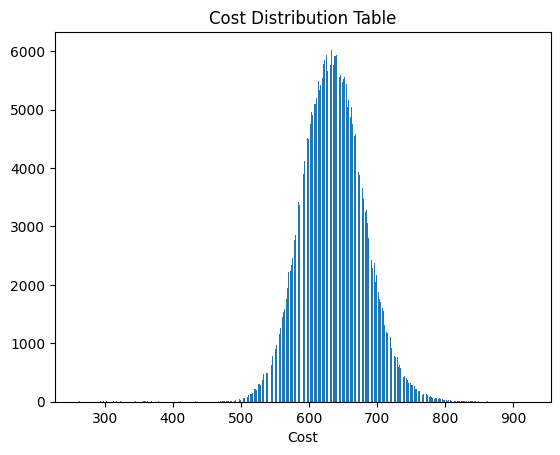

In [14]:
ax = plt.subplot()
plt.hist(df['cost'], bins = 1000)
plt.title("Cost Distribution Table")
ax.set_xlabel('Cost')
plt.show()

In [15]:
target = 'cost'
X = df.drop(columns = [target,'time'])
y = df[target]

In [16]:
y_pred_base = [y.mean()]*len(y)
baseline_mae = mean_absolute_error(y,y_pred_base)
print("The basline mae is:",baseline_mae)

The basline mae is: 36.24970675582704


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state=42)

In [29]:
model_lr = make_pipeline(
    OrdinalEncoder(handle_unknown='error'),
    SimpleImputer(strategy='median'),
    LinearRegression()
)

model_lr.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [30]:
y_pred_lr = model_lr.predict(X_val)

In [33]:
print("Model score is", model_lr.score(X_val,y_val))
print("Model mean absolute error is", mean_absolute_error(y_val, y_pred_lr))

Model score is 0.2558321768857754
Model mean absolute error is 30.97638515257325


In [34]:
model_r = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    Ridge()
)

model_r.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('ridge', Ridge())])

In [35]:
y_pred_r = model_r.predict(X_val)

In [36]:
print("Model score is", model_r.score(X_val,y_val))
print("Model mean absolute error is", mean_absolute_error(y_val, model_r.predict(X_val)))

Model score is 0.2558321676259383
Model mean absolute error is 30.97638557969982


In [37]:
model_l = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    LogisticRegression()
)

model_l.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
y_pred_l = model_l.predict(X_val)

In [ ]:
print("Model score is", model_l.score(X_val,y_val))
print("Model mean absolute error is", mean_absolute_error(y_val, model_l.predict(X_val)))

In [ ]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=20, max_depth=20)
)

model_rf.fit(X_train,y_train)

In [ ]:
y_pred_rf = model_rf.predict(X_val)

In [ ]:
print("Model score is", model_rf.score(X_val,y_val))
print("Model mean absolute error is", mean_absolute_error(y_val, y_pred_rf))

In [19]:
model_xgbc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=20, random_state=42, eval_metric='merror')
)

model_xgbc.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='merror',
                               feature_types=None, g...=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=20, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [20]:
y_pred_xgbc = model_xgbc.predict(X_val)

In [21]:
print("Model score is", model_xgbc.score(X_val,y_val))
print("Model mean absolute error is", mean_absolute_error(y_val, y_pred_xgbc))

Model score is 0.0
Model mean absolute error is 354.86079669297254
